In [ ]:
%pip install split-folders

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image
from glob import glob
import torch
import torchvision
from torchvision import transforms, models, datasets
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, dataset
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
import random
import splitfolders

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_path = '/content/drive/MyDrive/Plant_Disease_Dataset'

Mounted at /content/drive


In [ ]:
for i in os.listdir(data_path):
  new_loc = os.path.join(data_path, i)
  new_jpg = os.path.join(new_loc, '*.jpg')
  new_JPG = os.path.join(new_loc, '*.JPG')

  images_jpg = glob(new_jpg)
  images_JPG = glob(new_JPG)

  total_images = len(images_jpg) + len(images_JPG)

  print(f"{i}: {total_images} images")

cucumber_unhealthy: 500 images
tomato_late_blight: 500 images
tomato_healthy: 500 images
tomato_early_blight: 500 images
potato_late_blight: 504 images
potato_healthy: 500 images
potato_early_blight: 500 images
cucumber_healty: 500 images


In [ ]:
classes = os.listdir(data_path)
print(classes)

['cucumber_unhealthy', 'tomato_late_blight', 'tomato_healthy', 'tomato_early_blight', 'potato_late_blight', 'potato_healthy', 'potato_early_blight', 'cucumber_healty']


In [ ]:
splitfolders.ratio(data_path, seed = 1337, output = 'train-test-splitted', ratio = (0.6, 0.2, 0.2))

Copying files: 4004 files [01:32, 43.19 files/s] 


In [ ]:
train_data_dir = '/content/train-test-splitted/train'
test_data_dir = '/content/train-test-splitted/test'
val_data_dir = '/content/train-test-splitted/val'

In [ ]:
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=0, contrast=0.2, saturation=0, hue=0)
])

transform_tests = torchvision.transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
train_data = datasets.ImageFolder(train_data_dir, transform=transform_train)
test_data = datasets.ImageFolder(test_data_dir, transform=transform_tests)

train_loader = DataLoader(train_data, batch_size=24, drop_last=True, shuffle=True, num_workers=2)
validation_loader = DataLoader(test_data, batch_size=24, drop_last=True, shuffle=True, num_workers=2)

print(len(train_data))
print(len(test_data))

2402
802


In [ ]:
examples = next(iter(train_loader))
for label, img in enumerate(examples):
  print(img.shape)

torch.Size([24, 3, 224, 224])
torch.Size([24])


Gambar acak dari data train loader: 


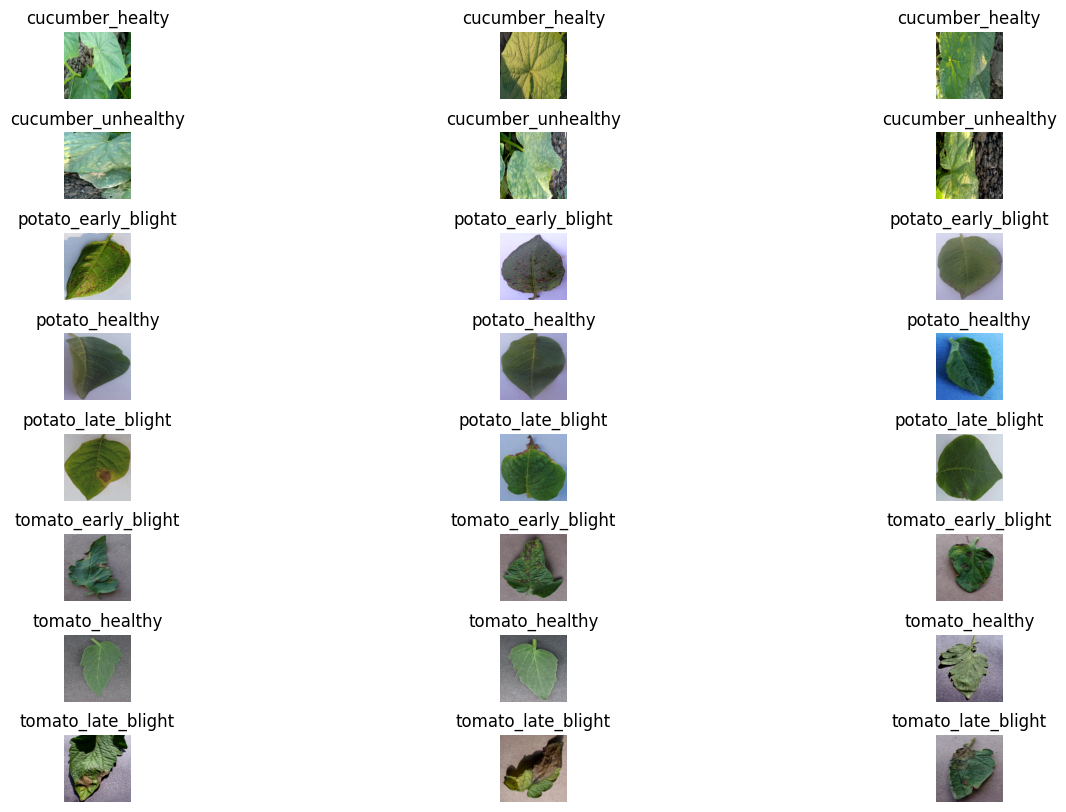

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def show_random_images(loader, classes, num_images_per_class=3):
  data_iter = iter(loader)

  num_classes = len(classes)
  fig, axes = plt.subplots(nrows=num_classes, ncols=num_images_per_class, figsize=(15, 10))

  for i, class_name in enumerate(classes):
    class_indices = np.where(np.array(loader.dataset.targets) == i)[0]
    selected_indices = np.random.choice(class_indices, size=num_images_per_class, replace=False)

    for j, idx in enumerate(selected_indices):
      images, labels = loader.dataset[idx]
      ax = axes[i, j] if num_classes > 1 else axes[j]
      ax.imshow(np.transpose(images.numpy(), (1, 2, 0)))
      ax.set_title(class_name)
      ax.axis('off')

  plt.subplots_adjust(wspace=0.5, hspace=0.5)
  plt.show()

classes = train_data.classes

print("Gambar acak dari data train loader: ")
show_random_images(train_loader, classes)

In [ ]:
import torch.nn as nn

class ModifiedCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.2):
        super(ModifiedCNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.dense_layers = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)

        x = x.mean([2, 3])

        x = self.dense_layers(x)

        return x

num_classes = 8
dropout_rate = 0.001
model = ModifiedCNN(num_classes, dropout_rate=dropout_rate)
print(model)


ModifiedCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.001, inplace=False)
    (1): Linear(in_features=128, out_features=64, bi

In [ ]:
# device = "cpu"
# num_classes = 8
# cnn_model =  ModifiedCNN(num_classes)
# cnn_model.to(device)

ModifiedCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=128, out_features=64, bias

In [ ]:
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = cnn_model.to(device)

num_epochs = 20
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    cnn_model.train()
    correct_train = 0
    total_train = 0
    running_loss_train = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        running_loss_train += loss.item()

    train_accuracy = (correct_train / total_train) * 100
    train_loss = (running_loss_train / len(train_loader)) * 100
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Test the model
    cnn_model.eval()
    correct_test = 0
    total_test = 0
    running_loss_test = 0.0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            running_loss_test += loss.item()

    test_accuracy = (correct_test / total_test) * 100
    test_loss = (running_loss_test / len(validation_loader)) * 100
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    # Print and log metrics
    print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.2f}%, Train Accuracy: {train_accuracy:.2f}%, Test Loss: {test_loss:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

Epoch 1/20, Train Loss: 118.48%, Train Accuracy: 55.75%, Test Loss: 101.21%, Test Accuracy: 61.87%
Epoch 2/20, Train Loss: 76.61%, Train Accuracy: 69.58%, Test Loss: 74.98%, Test Accuracy: 72.35%
Epoch 3/20, Train Loss: 66.00%, Train Accuracy: 74.17%, Test Loss: 53.72%, Test Accuracy: 77.65%
Epoch 4/20, Train Loss: 59.03%, Train Accuracy: 77.12%, Test Loss: 68.59%, Test Accuracy: 71.46%
Epoch 5/20, Train Loss: 59.13%, Train Accuracy: 77.17%, Test Loss: 59.20%, Test Accuracy: 75.88%
Epoch 6/20, Train Loss: 53.35%, Train Accuracy: 79.42%, Test Loss: 192.38%, Test Accuracy: 35.48%
Epoch 7/20, Train Loss: 48.81%, Train Accuracy: 81.12%, Test Loss: 43.07%, Test Accuracy: 84.34%
Epoch 8/20, Train Loss: 49.74%, Train Accuracy: 81.25%, Test Loss: 51.76%, Test Accuracy: 80.18%
Epoch 9/20, Train Loss: 45.21%, Train Accuracy: 83.33%, Test Loss: 64.24%, Test Accuracy: 72.73%
Epoch 10/20, Train Loss: 42.95%, Train Accuracy: 83.38%, Test Loss: 71.45%, Test Accuracy: 69.57%
Epoch 11/20, Train Loss: 4

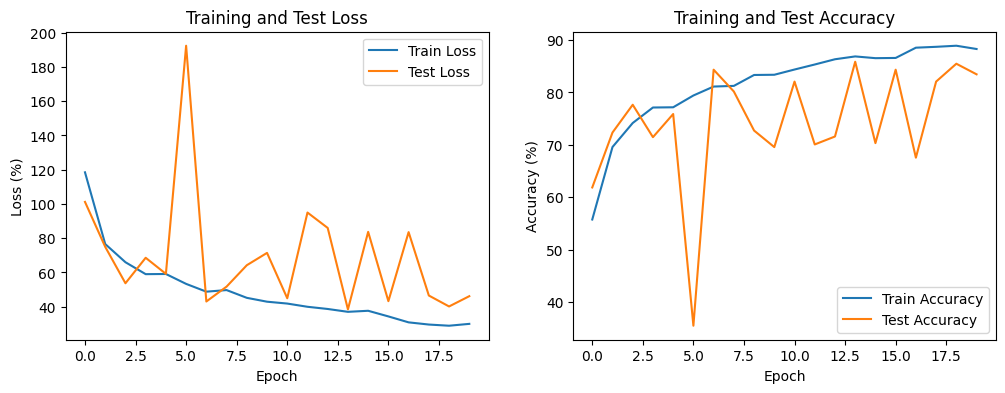

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (%)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


Classification Report:
                     precision    recall  f1-score   support

    cucumber_healty       0.74      0.99      0.85        97
 cucumber_unhealthy       1.00      0.61      0.75        99
potato_early_blight       0.66      0.77      0.71        97
     potato_healthy       0.75      0.56      0.64       100
 potato_late_blight       0.76      0.92      0.83       102
tomato_early_blight       0.95      0.90      0.92       100
     tomato_healthy       1.00      0.97      0.98        97
 tomato_late_blight       0.92      0.93      0.93       100

           accuracy                           0.83       792
          macro avg       0.85      0.83      0.83       792
       weighted avg       0.85      0.83      0.83       792



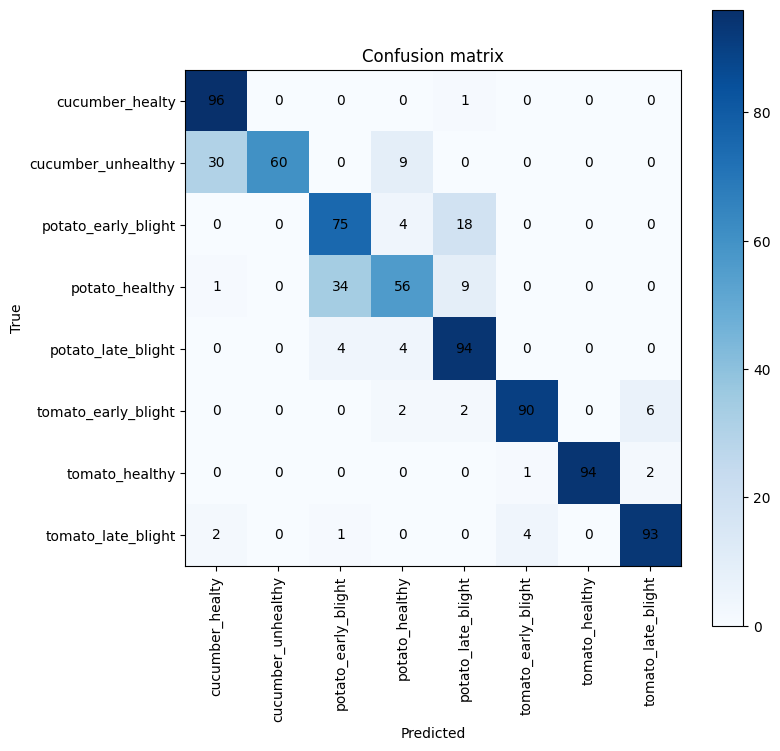

In [ ]:
# Fungsi untuk mendapatkan prediksi model
def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_preds, all_labels

model.eval()
y_pred, y_true = get_predictions(model, validation_loader)

cm = confusion_matrix(y_true, y_pred)

class_names = classes

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center')

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

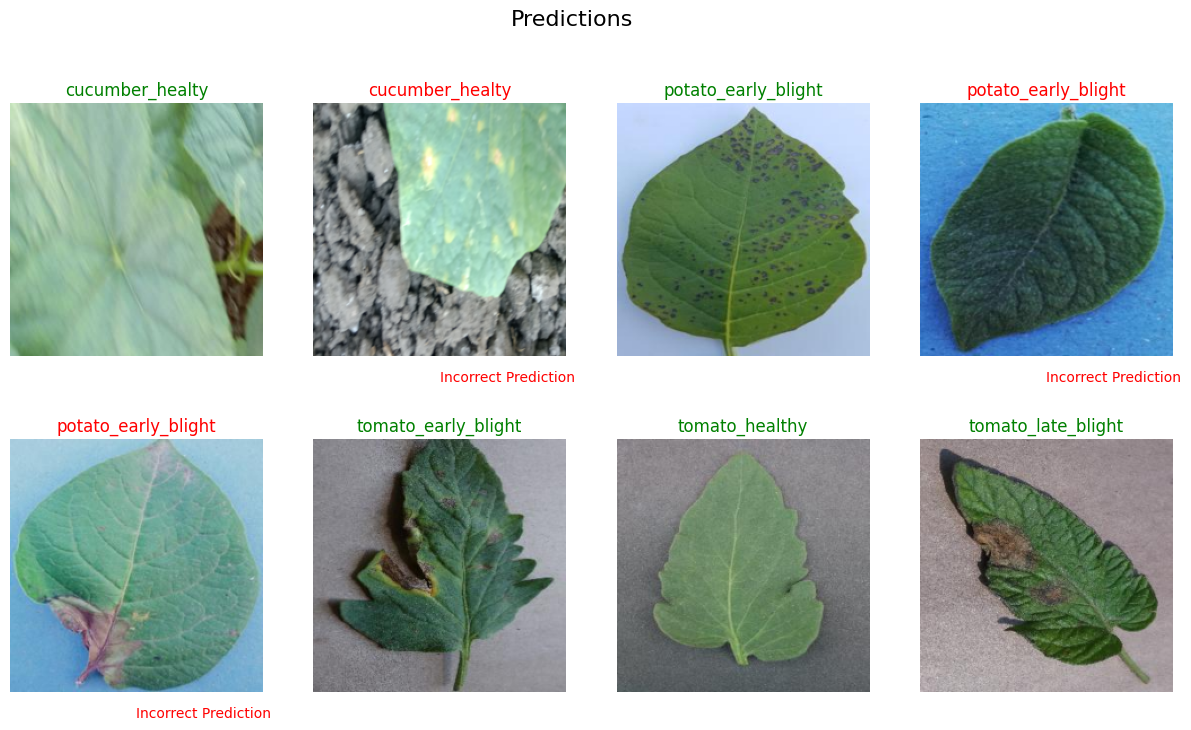

In [ ]:
class_names = classes

# Load trained model here
model = model
model.eval()

# Transform for the input image
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Path to the test images folder
test_folder = "/content/train-test-splitted/test"

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up a subplot for the predictions
fig, axs = plt.subplots(2, 4, figsize=(15, 8))
fig.suptitle('Predictions', fontsize=16)

# Iterate through all subplots
for i in range(2):
    for j in range(4):
        # Calculate the index in the flat iteration
        index = i * 4 + j

        # Skip if all images have been processed
        if index >= len(class_names):
            break

        # Get the class name for the current subplot
        class_name = class_names[index]

        # Get the list of image files for the class
        class_folder = os.path.join(test_folder, class_name)
        image_files = os.listdir(class_folder)

        # Determine the number of images to predict
        num_images_to_predict = 2 if i == 0 and j < 2 else 1

        # Skip if there are not enough images
        if len(image_files) < num_images_to_predict:
            continue

        # Randomly select different images for each prediction
        image_indices = random.sample(range(len(image_files)), num_images_to_predict)

        # Iterate over selected image indices
        for k in range(num_images_to_predict):
            image_index = image_indices[k]
            image_path = os.path.join(class_folder, image_files[image_index])
            img = Image.open(image_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(device)

            # Make prediction
            with torch.no_grad():
                output = model(img)
                _, predicted = torch.max(output, 1)
                predicted_class = class_names[predicted.item()]

            # Display the image with title
            axs[i, j].imshow(img.cpu().squeeze().permute(1, 2, 0).numpy())  # Move to CPU before converting to numpy
            title_color = 'green' if predicted_class == class_name else 'red'
            axs[i, j].set_title(predicted_class, color=title_color)
            axs[i, j].axis('off')

            if title_color == 'red':
                axs[i, j].text(0.5, -0.1, 'Incorrect Prediction', color='red', transform=axs[i, j].transAxes)

plt.show()
